# Product Background Creation

## Imports and Visualization

In [2]:
%%capture
%pip install opencv-python-headless numpy
%pip install scipy
%pip install matplotlib
%pip install rembg
%pip install openai
%pip install --upgrade pillow

In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from rembg import remove
from scipy.ndimage import binary_fill_holes
from PIL import Image

In [4]:
# Display the image
def display_rgba_image(image_array, titles=[]):

    if isinstance(image_array, list):
        if (len(titles) == 0):
            titles = [i for i in range(len(image_array))]
        
        fig, axes = plt.subplots(figsize=(15, 10), nrows=math.ceil(len(image_array) / 3), ncols=np.min([3, len(image_array)]))
        
        axes = np.array(axes).reshape(-1)
        
        for ax, img, title in zip(axes, image_array, titles):
            img_rgb = np.asarray(img, dtype=np.uint8)
            ax.set_facecolor((0,1,0))
            ax.imshow(img_rgb)
            ax.set_title(title)
            
        for extra_ax in axes[len(image_array):]:
            extra_ax.axis('off')

    else:
        fig, axes = plt.subplots(nrows=1, ncols=1)
        axes.set_facecolor((0,1,0))
        img_rgb = np.asarray(image_array, dtype=np.uint8)
        axes.imshow(img_rgb)
    
    plt.show()

## Removing Product Image BG
Currently removes white BG, can be more complex as necessary

In [5]:
def remove_bg_unicolor(image, color='w'):
    image = image.convert("RGBA")

    # Get the pixel data
    pixels = image.getdata()
    
    # Create a new image with transparent background
    new_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
    
    # Iterate through each pixel
    for x, y in [(x, y) for x in range(image.width) for y in range(image.height)]:
        r, g, b, a = pixels[y * image.width + x]
        # If the pixel is not white, add it to the new image
        if r != 255 or g != 255 or b != 255:
            new_image.putpixel((x, y), (r, g, b, a))
    return new_image
    """
    image = input_img.copy()
    if (color == 'w'):
        white = np.all(image[:, :, :3] >= [240, 240, 240], axis=2)
        image[white, :] = 0
        return image
    if (color == 'b'):
        white = np.all(image[:, :, :3] <= [15, 15, 15], axis=2)
        image[white, :] = 0
        return image
    else:
        return remove_bg_anycolor(image)
    """
def remove_bg_anycolor(input_img):
    image = remove(input_img).copy()
    return image
dirs = os.listdir("Temp")
print(dirs)

NameError: name 'os' is not defined

In [57]:
import os
import csv

filenames = os.listdir('SKUs')

cleaned_filenames = [name.replace('.png', '') for name in filenames]

# Create a CSV file
with open('products.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Product Name'])
    # Write the cleaned filenames
    for name in cleaned_filenames:
        writer.writerow([name])

In [59]:
import pickle

# Replace 'your_file.pkl' with the path to your pickle file
with open('../../ComboStoreKS/joebob/backend/generateData/all_data.pickle', 'rb') as file:
    data = pickle.load(file)

print(data)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [43]:
import openpyxl

# Function to write an array of strings to the first column of an Excel file
def write_to_excel(strings, filename):
    # Create a new workbook and select the active worksheet
    workbook = openpyxl.Workbook()
    sheet = workbook.active
    
    # Write each string to the first column
    for i, string in enumerate(strings, start=1):
        sheet.cell(row=i, column=1).value = string
    
    # Save the workbook
    workbook.save(filename)

# Example array of strings
strings = ["Hello", "World", "This", "Is", "An", "Array"]

# Write the array to the first column of 'output.xlsx'
write_to_excel(strings, 'output.xlsx')

### Test Image: Coca-Cola Bottle

In [47]:
x = [Image.open('SKUs/COKE DIET 24-20OZ.png'), Image.open('SKUs/COKE ORIGINAL 8-2LT.png')]
bg = Image.open('BGs/refreshment_BG.png')

#display_rgba_image([x, bg])

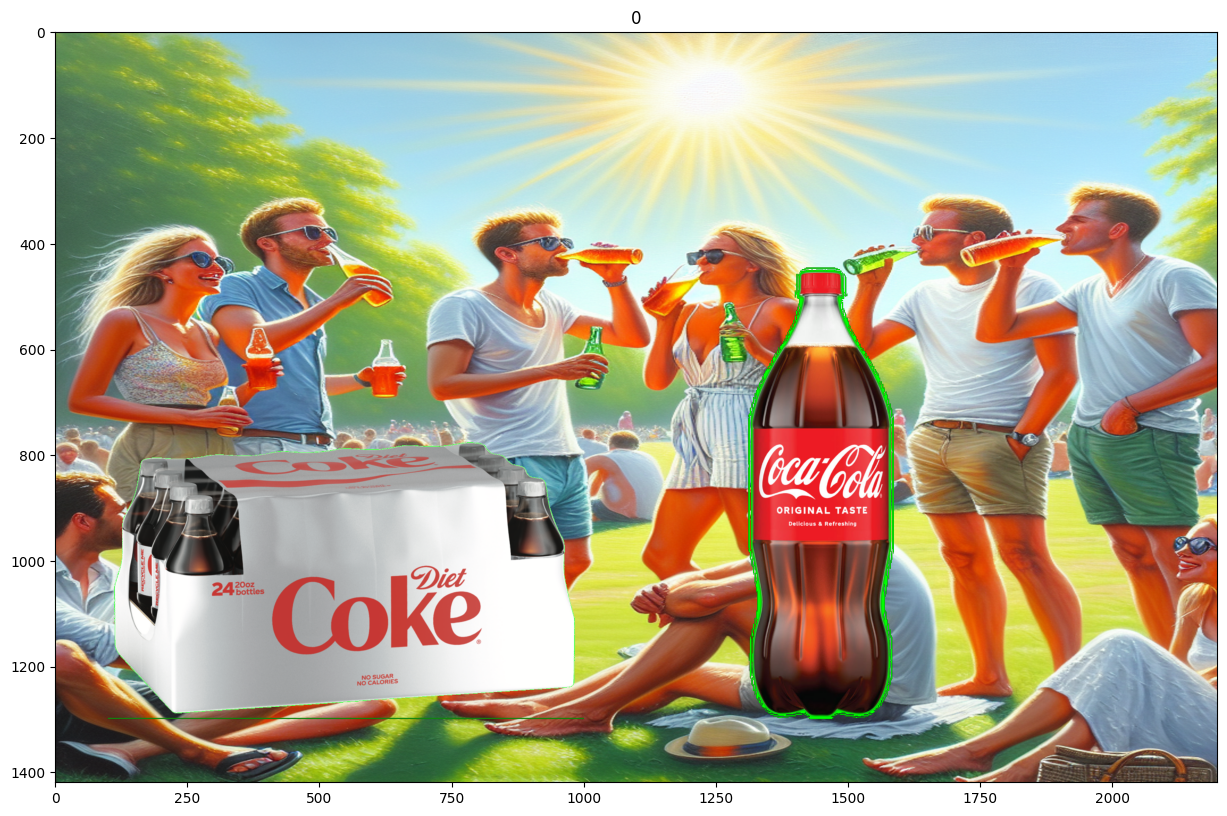

In [52]:
y = overlay_product_image_on_bg(x, bg, frame=(350, 100, 1900, 1300), bg_color='none')
display_rgba_image([y])

## Overlaying Product Image onto BG
No Image Gen BG yet

In [51]:
def scale_image(image, bg_shape, bg_partition_shape, scale):
    image_shape = image.size[::-1]
    x_scale = bg_shape[1] / image_shape[1]
    y_scale = bg_shape[0] / image_shape[0]
    scale_up = scale * (y_scale if x_scale > y_scale else x_scale)
    x_size = scale_up * image_shape[1]
    y_size = scale_up * image_shape[0]
    if (x_size > bg_partition_shape[1]):
        partition_shrink = bg_partition_shape[1] / x_size
        x_size *= partition_shrink * scale
        y_size *= partition_shrink * scale
    new_dims = (int(x_size), int(y_size))
    return cv2.cvtColor(np.array(image.resize(new_dims)), cv2.COLOR_RGB2RGBA)

def mask_bg(image, bg_color='any'):
    if bg_color == 'any':
        scaled_product_rgba_nb = remove_bg_anycolor(image)
    elif bg_color == 'none':
        scaled_product_rgba_nb = image
    else:
        scaled_product_rgba_nb = remove_bg_unicolor(image, color=bg_color) 
    # creating mask and applying to product
    mask = np.asarray(scaled_product_rgba_nb[:, :, 3] != 0)
    mask = np.repeat(binary_fill_holes(mask[:,:])[:,:,np.newaxis], 4, axis=2).astype(np.uint8)
    image *= mask
    return image, mask

def overlay_product_image_on_bg(product_img, bg_img, frame=None, scale=1, bg_color='any'):
    """
    - frame: A tuple (top, left, right, bottom) defining the area to fit the text in.
    """
    bg_img = bg_img.resize((2199, 1419))
    bg_shape = bg_img.size[::-1]
    if (frame != None):
        frame_height = min(abs(frame[3] - frame[0]), bg_shape[0])
        frame_width = min(abs(frame[2] - frame[1]), bg_shape[1])
        bg_shape = (frame_height, frame_width)
    num_products = len(product_img)
    bg_img_rgba = cv2.cvtColor(np.array(bg_img), cv2.COLOR_RGB2RGBA)
    bg_partition_shape = (bg_shape[0], (bg_shape[1] / num_products))
    
    
    for idx, product in enumerate(product_img):
        product_shape = product.size[::-1]
        
        # scaling product image relative to bg size
        scaled_product_rgba = scale_image(product, bg_shape, bg_partition_shape, np.min([1, scale]))
        scaled_product_shape = np.shape(scaled_product_rgba)
        
        # removing product background
        scaled_product_rgba, mask = mask_bg(scaled_product_rgba, bg_color=bg_color)
        # masking bg image in evenly spaced position
        center_y = math.floor((bg_shape[0] - scaled_product_shape[0]) / 2)
        center_x = math.floor(idx * bg_partition_shape[1] + (bg_partition_shape[1] - scaled_product_shape[1]) / 2)
        if (frame):
            center_y += frame[0]
            center_x += frame[1]
        bg_img_rgba[center_y + int((bg_partition_shape[0] - scaled_product_shape[0]) / 2):scaled_product_shape[0] + center_y + int((bg_partition_shape[0] - scaled_product_shape[0]) / 2), center_x:scaled_product_shape[1] + center_x] *= 1 - mask
        bg_img_rgba[center_y + int((bg_partition_shape[0] - scaled_product_shape[0]) / 2):scaled_product_shape[0] + center_y + int((bg_partition_shape[0] - scaled_product_shape[0]) / 2), center_x:scaled_product_shape[1] + center_x] += scaled_product_rgba
        
    # overlaying product image
    return Image.fromarray(bg_img_rgba)
    

## Generating Image BG

In [223]:
from openai import OpenAI, OpenAIError
from PIL import Image, ImageDraw, ImageFont, ImageStat, ImageColor
import requests
from io import BytesIO
import random
import os

In [22]:
client = OpenAI()

### TODO: WRITE ADAPTIVE PROMPT WITH GPT ###
occasion = "Hydration for Runners"
bg_prompt = """Generate an image that represents a background for a product promotion. 
                The image should be composed of two main elements: a ground and a background.
                The ground should feature a table with a matte neutral color, positioned about 
                a quarter from the bottom of the image. This table will serve as the base for 
                multiple products which will be added later. Do not include a product. The background 
                should depict a blurred scene that corresponds to the target consumer or purpose 
                or occasion of the promotion, which is {occasion}. The scene should 
                be designed in such a way that even a viewer without any context can understand 
                the occasion or purpose. To ensure consistency across all images, use a DSLR camera 
                with a 50mm lens. Set the aperture to f/1.8 to achieve a shallow depth of field, 
                which will help blur the background. The ISO should be set to 100 for optimal 
                image quality, and the shutter speed can be adjusted based on the lighting conditions.
                Remember, the goal is to create a consistent series of images where the only variable 
                element is the occasion or purpose of the promotion, represented in the background scene."""

In [23]:
def generate_bg(bg_prompt, model="dall-e-2"):
    response = client.images.generate(
        model=model,
        prompt=bg_prompt,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    
    image_url = response.data[0].url
    bg_img = Image.open(requests.get(image_url, stream=True).raw)
    return cv2.cvtColor(np.array(bg_img.convert('RGBA')), cv2.COLOR_RGB2RGBA)

### Test BG

### Soccer BG

In [25]:
bg_prompt_general_runner = """Generate an image that represents a background for a product promotion. 
                The image should be composed of two main elements: a close-up ground and a background.
                The ground should feature a close surface with a matte neutral color, occupying  
                the bottom quarter of the image. This surface will serve as the base for 
                multiple products which will be added later. Do not include a product. The background 
                should depict a blurred scene that corresponds to the target consumer or purpose 
                or occasion of the promotion, which is 'hydration for runners'. The scene should 
                be designed in such a way that even a viewer without any context can understand 
                the occasion or purpose. To ensure consistency across all images, use a DSLR camera 
                with a 50mm lens. Set the aperture to f/1.8 to achieve a shallow depth of field, 
                which will help blur the background. The ISO should be set to 100 for optimal 
                image quality, and the shutter speed can be adjusted based on the lighting conditions.
                Remember, the goal is to create a consistent series of images where the only variable 
                element is the occasion or purpose of the promotion, represented in the background scene."""

## Adding Text and Designs

In [1158]:
from PIL import Image, ImageOps, ImageEnhance, ImageDraw, ImageFilter

def draw_title_text(image, text, font, area, color='white'):
    """
    Draws centered text on an image with the font size scaled to fit within a specified area.

    Parameters:
    - img_path: Path to the image file.
    - text: Text string to be written.
    - font_path: Path to the .ttf font file.
    - area: A tuple (top, left, right, bottom) defining the area to fit the text in.
    - max_font_size: Maximum possible starting font size.

    Returns: Image with text centered in given box
    """
    
    draw = ImageDraw.Draw(image)
    
    # TODO: ADD PRESET POSITIONS FOR HEADER, DISCOUNT, SKU, ETC
    area_width = abs(min(area[2] - area[1], image.size[0]))
    area_height = abs(min(area[3] - area[0], image.size[1]))
    font = font.font_variant(size=area_height)
    
    # Scale Font Size to Area
    text_width = draw.textlength(text, font=font)
    text_height = area_height

    if (text_width > area_width):
        text_height = math.floor(text_height * (area_width / text_width))
        font = font.font_variant(size=text_height)
        text_width = draw.textlength(text, font=font)

    # Center Position
    x = area[1] + (area_width - text_width) // 2
    y = area[0] + (area_height - text_height) // 2
    
    draw.text((x, y), text, font=font, fill=color)

def add_box(image, area, color='gray', outline='gray', rounded=False, isOutline=False):
    """
    - area: A tuple (top, left, right, bottom) defining the area to fit the text in.
    """
    if (not isOutline):
        outline = color
    draw = ImageDraw.Draw(image)
    rect_width = area[2] - area[1]
    rect_height = area[3] - area[0]
    if (rounded):
        corner_radius = min(rect_width, rect_height)
        draw.rounded_rectangle(area, fill=color, outline=outline, radius=corner_radius, width=10)
    else:
        draw.rectangle(area, fill=color, outline=outline, width=10)

def add_discount_sticker(image, discount, font, position, diameter):
    draw = ImageDraw.Draw(image)
    circle_color = 'white'
    draw.ellipse([position[0], position[1], position[0] + diameter, position[1] + diameter], outline=circle_color, fill=circle_color)
    area = (position[1] + diameter * 0.1, position[0], position[0] + diameter, position[1] + diameter * 0.65)
    draw_title_text(image, f"{discount}%", font, area, color='black')
    draw_title_text(image, "DISCOUNT", font, (position[1] + 275, position[0] + 76, position[0] + 345, position[1] + 337), color='black')

def add_SKU_label(image, SKUs, font, product_image_area):
    top, left, right, bottom = product_image_area
    n = len(SKUs)
    if (n <= 1):
        draw_title_text(image, SKUs[0], font, (bottom, left, right, bottom + 70), color='black')
        return

    width = right - left
    partition_width = width / n
    partitions = []
    for i in range(n):
        partition_left = left + i * partition_width
        partition_right = partition_left + partition_width
        draw_title_text(image, SKUs[i], font, (bottom, partition_left, partition_right, bottom + 70), color='black')
        if (i == 0 or i == n - 2):
            draw_title_text(image, "+", font, (bottom, partition_left, partition_right + partition_width, bottom + 70), color='black')

def create_reflection(original_image, footer_height=250, reflection_opacity=0.4):    
    original_image = original_image.filter(ImageFilter.GaussianBlur(radius=4))
    reflected_image = ImageOps.flip(original_image)
    reflected_image = reflected_image.crop((0, 0, original_image.width, footer_height))
    gradient = Image.new('L', (original_image.width, footer_height), color=0xFF)
    for y in range(footer_height):
        transparency = int((255 * reflection_opacity) * (1 - y / footer_height))
        for x in range(original_image.width):
            gradient.putpixel((x, y), transparency)
    reflected_image = reflected_image.convert("RGBA")
    white_bg = Image.new('RGBA', reflected_image.size, (255, 255, 255, 255))
    blended_reflection = Image.composite(reflected_image, white_bg, gradient)
    total_height = original_image.height + footer_height
    footer_image = Image.new('RGBA', (original_image.width, total_height), (255, 255, 255, 255))
    footer_image.paste(original_image, (0, 0))
    footer_image.paste(blended_reflection, (0, original_image.height), blended_reflection)
    footer_image = footer_image.filter(ImageFilter.BLUR)    
    return footer_image

def add_quantity_stickers(image, product_frame, quantities, font, color="gray", outline="darkgrey", text_color="black"):
    draw = ImageDraw.Draw(image)
    num_products = len(quantities)
    diameter = 200
    top, left, right, bottom = product_frame
    width = right - left
    height = bottom - top
    partition_width = width / num_products
    partitions = []
    for i in range(num_products):
        partition_left = left + i * partition_width
        partition_right = partition_left + partition_width
        if (num_products == 1):
            part_left, part_top, part_right, part_bottom = (partition_left + 400, product_frame[0] + height * 0.65 - 100, partition_left + 600, product_frame[0] + height * 0.65 + 100)
        else:
            part_left, part_top, part_right, part_bottom = (partition_left + 125, product_frame[0] + height * 0.65 - 100, partition_left + 325, product_frame[0] + height * 0.65 + 100)
        draw.ellipse((part_left, part_top, part_right, part_bottom), outline=outline, fill=color, width=6)
        draw_title_text(image, str(quantities[i]) + "x", font, (part_top, part_left + 15, part_right - 15, part_bottom - 50), color=text_color)


## Bringing Image-Gen and Product Placement Together

In [30]:
def generate_product_card(product_image, bg_prompt, frame=None, scale=1, bg_color='any'):
    try:
        bg = generate_bg(bg_prompt)
        return overlay_product_image_on_bg(product_image, bg, frame, scale, bg_color=bg_color)
    except OpenAIError as e:
        print(e.http_status)
        print(e.error)

def generate_product_card_with_bg(product_image, bg_image, frame=None, scale=1, bg_color='any'):
    return overlay_product_image_on_bg(product_image, bg_image, frame, scale, bg_color=bg_color)

## Bringing It All Together

In [1127]:
def generate_card_basic(SKUs, dev_set, bundle_ID, quantities, max_quantity, font, discount, theme_color='white', text_color='black', bg_color='any'):

    bg_image = Image.open("BGs/" + dev_set + "_BG.png")
    product_frame = (350, 100, 1900, 1300)

    product_images = []
    for SKU in SKUs:
        product_images.append(Image.open("SKUs/" + SKU + ".png"))
    
    # Add BG Reflection
    bg_image = create_reflection(bg_image)
    
    # Overlay Products
    product_on_bg = generate_product_card_with_bg(product_images, bg_image, frame=product_frame, bg_color=bg_color)
    # Output Dims will be 2199 x 1419

    # Add Header
    add_box(product_on_bg, (0, 0, product_on_bg.size[0], 230), color=theme_color)
    theme_rgb = ImageColor.getrgb(theme_color)
    theme_color_dark = tuple(int(c * 0.8) for c in theme_rgb)
    add_box(product_on_bg, (-100, 26, 880, 213), color=theme_color_dark, rounded=True)
    draw_title_text(product_on_bg, bundle_ID, font, (40, 46, 745, 165), color=text_color)
    add_box(product_on_bg, (1700, 60, 2000, 170), color=theme_color, outline=text_color, isOutline=True, rounded=False)
    draw_title_text(product_on_bg, "Max: " + str(max_quantity), font, (60, 1700, 2000, 150), color=text_color)
    
    
    # Add Footer
    add_SKU_label(product_on_bg, SKUs, font, product_frame)

    # Add Discount Sticker
    add_discount_sticker(product_on_bg, discount, font, (1700, 200), 400)

    # Add Quantities
    add_quantity_stickers(product_on_bg, product_frame, quantities, font, color=theme_color, outline=theme_color_dark, text_color=text_color)

    return product_on_bg

## Testing

### Multi-Product Test

In [ ]:
test_images = []
for image_name in os.listdir("Product_Assets"):
    if image_name.lower().endswith('.jpg'):  # Ensure the file is a JPG
        filename = os.path.join("Product_Assets", image_name)
        print(filename)

        image = Image.open(filename)
        if image is not None:  # Check if the image has been loaded properly
            test_images.append(image)
        else:
            print(f"Failed to load image: {filename}")
    else:
        print(f"Skipped non-JPG file: {image_name}")


In [ ]:
display_rgba_image(test_images)

In [ ]:
rand_test_images = [test_images[random.randint(0,len(test_images) - 1)] for i in range(2)]
x = 2
#rand_test_images = [test_images[i] for i in range(x, x + 2)]

## Samples

In [1154]:
######################################## INPUTS ########################################

#Bundle SKUs
SKUs = []
#SKUs.append('KO_2Lx4')
#SKUs.append('KO_12OZx24')
SKUs.append('SPRITE LEMON LIME 24-20OZ')
#SKUs.append('SPRITE LEMON LIME 24-20OZ')

# Development Set
dev_set = "MealsAFH"

# Primary Brands (that appears first)
primary_brand = "ba"

# Quantities of each product in order
quantities = [4, 10, 14][:len(SKUs)]

# Max number of purchases of that bundle per user
max_purchases = 4

# Discount on bundle
discount = 5

In [1159]:
font = ImageFont.truetype("TCCC-UnityCondensedPC-Bold.ttf", size=400)

themes = {
    'jm': ('khaki', 'black'),
    'monster': ('lime', 'black'), 
    'bang': ('purple', 'white'), 
    'sprite': ('limegreen', 'black'), 
    'fanta': ('orange', 'black'), 
    'vw': ('crimson', 'white'), 
    'sw': ('dodgerblue', 'white'), 
    'powerade': ('deepskyblue', 'black'), 
    'drp': ('firebrick', 'white'), 
    'kod': ('lightgrey', 'black'), 
    'koz': ('red', 'white'), 
    'kov': ('moccasin', 'black'), 
    'koc': ('fuchsia', 'white'), 
    'kof': ('magenta', 'white'), 
    'ko': ('red', 'white'), 
    'mm': ('yellowgreen', 'black'), 
    'gp': ('peru', 'white'), 
    'ba': ('coral', 'black'), 
    'reign': ('slategrey', 'white'), 
    'cp': ('darkgoldenrod', 'white'), 
    'fairlife': ('skyblue', 'black'), 
    'fuze': ('gold', 'black'), 
    'dunkin': ('darkorange', 'white'), 
    'seagram': ('darkgreen', 'white'), 
    'barq': ('darkred', 'white'), 
    'aha': ('plum', 'black'), 
    'dasani': ('aqua', 'black'), 
    'fresca': ('powderblue', 'black'), 
    'ch': ('darkturquoise', 'white'), 
    'nos': ('dodgerblue', 'white'), 
    'pt': ('gold', 'black'), 
    'ga': ('darkgreen', 'white'), 
    'tc': ('yellow', 'black'), 
    'inca': ('gold', 'black'), 
    'lp': ('silver', 'black'), 
    'rc': ('royalblue', 'white'), 
    'core': ('silver', 'black'), 
    'water': ('silver', 'black'), 
    'orange': ('silver', 'black')
}

In [1160]:
basic_card = generate_card_basic(SKUs,
                                 dev_set,
                                 "X#X#########",
                                 quantities,
                                 max_purchases,
                                 ImageFont.truetype("TCCC-UnityCondensedPC-Bold.ttf"),
                                 discount,
                                 theme_color=themes[primary_brand][0],
                                 text_color = themes[primary_brand][1],
                                 bg_color='none')

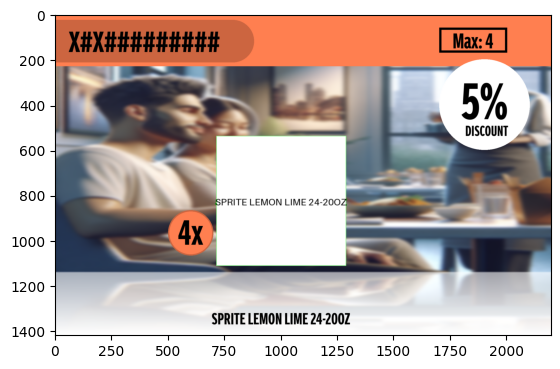

In [1161]:
display_rgba_image(basic_card)

In [743]:
#basic_card.save('HealthBundle.png')

In [61]:
# DO NOT RUN
with open('../../ComboStoreKS/joebob/backend/generateData/all_data.pickle', 'rb') as file:
    data = pickle.load(file)

from PIL import Image, ImageDraw, ImageFont

# Create a new image with transparent background
for SKU in data:
    print(SKU)
    #if ("/" in SKU):
        #SKU.replace("/", "-")
        #continue
    #img = Image.new('RGBA', (500, 500), (0, 0, 0, 0))
    
    # Create a draw object
    #draw = ImageDraw.Draw(img)
    
    # Draw a square in the middle of the image
    #top_left = ((img.width - 300) // 2, (img.height - 300) // 2)
    #bottom_right = (top_left[0] + 300, top_left[1] + 300)
    #draw.rectangle([top_left, bottom_right], fill="white")
    
    # Draw some text in the middle of the square
    #font = ImageFont.load_default()
    #draw_title_text(img, SKU, font, (top_left[1], top_left[0], bottom_right[1], bottom_right[0]), color='black')
    
    # Save the image
    #img.save("SKUs/" +SKU + ".png")


datasets


In [932]:
print(themes.values())

dict_values(['khaki', 'lime', 'purple', 'limegreen', 'orange', 'crimson', 'dodgerblue', 'deepskyblue', 'firebrick', 'lightgrey', 'red', 'moccasin', 'fuchsia', 'magenta', 'red', 'yellowgreen', 'peru', 'coral', 'slategrey', 'darkgoldenrod', 'skyblue', 'gold', 'darkorange', 'darkgreen', 'darkred', 'plum', 'aqua', 'powderblue', 'darkturquoise', 'dodgerblue', 'gold', 'darkgreen', 'yellow', 'gold', 'silver', 'royalblue', 'silver', 'silver', 'silver'])


In [ ]:
#img = Image.new('RGBA', (500, 500), (0, 0, 0, 0))
    
# Create a draw object
#draw = ImageDraw.Draw(img)

# Draw a square in the middle of the image
#top_left = ((img.width - 300) // 2, (img.height - 300) // 2)
#bottom_right = (top_left[0] + 300, top_left[1] + 300)
#draw.rectangle([top_left, bottom_right], fill="white")

# Draw some text in the middle of the square
#font = ImageFont.load_default()
#draw_title_text(img, SKU, font, (top_left[1], top_left[0], bottom_right[1], bottom_right[0]), color='black')

# Save the image
#img.save("SKUs/" +SKU + ".png")